In [1]:
# Sales Data Analysis: Classification, Clustering & Pattern Mining
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, accuracy_score, f1_score, silhouette_score)
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load and explore the dataset
print("=== SALES DATA ANALYSIS ===")
print("Loading and exploring the dataset...\n")
df = pd.read_csv("/content/sample_data/sales_data.csv")
print("Dataset Info:")
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

=== SALES DATA ANALYSIS ===
Loading and exploring the dataset...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product_ID            1000 non-null   int64  
 1   Sale_Date             1000 non-null   object 
 2   Sales_Rep             1000 non-null   object 
 3   Region                1000 non-null   object 
 4   Sales_Amount          1000 non-null   float64
 5   Quantity_Sold         1000 non-null   int64  
 6   Product_Category      1000 non-null   object 
 7   Unit_Cost             1000 non-null   float64
 8   Unit_Price            1000 non-null   float64
 9   Customer_Type         1000 non-null   object 
 10  Discount              1000 non-null   float64
 11  Payment_Method        1000 non-null   object 
 12  Sales_Channel         1000 non-null   object 
 13  Region_and_Sales_Rep  1000 non-null   object

In [2]:
# ==========================================
# PART 1: DATA PREPROCESSING
# ==========================================

print("\n" + "="*50)
print("PART 1: DATA PREPROCESSING")
print("="*50)

# Create target variables for classification
# Target 1: High vs Low Sales (based on median)
median_sales = df['Sales_Amount'].median()
df['High_Sales'] = (df['Sales_Amount'] > median_sales).astype(int)

# Target 2: Customer segment based on quantity and amount
df['Customer_Segment'] = pd.cut(df['Sales_Amount'],
                               bins=[0, 1000, 3000, float('inf')],
                               labels=['Low', 'Medium', 'High'])

print(f"High Sales Distribution:")
print(df['High_Sales'].value_counts())
print(f"\nCustomer Segment Distribution:")
print(df['Customer_Segment'].value_counts())

# Encode categorical variables
categorical_columns = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type',
                      'Payment_Method', 'Sales_Channel']

# Label encoding for categorical variables
label_encoders = {}
df_encoded = df.copy()

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select features for modeling
feature_columns = ['Sales_Rep_encoded', 'Region_encoded', 'Quantity_Sold',
                  'Product_Category_encoded', 'Unit_Cost', 'Unit_Price',
                  'Customer_Type_encoded', 'Discount', 'Payment_Method_encoded',
                  'Sales_Channel_encoded']

X = df_encoded[feature_columns]
y_binary = df_encoded['High_Sales']  # Binary classification target

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print("\nFeatures selected for modeling:")
print(feature_columns)


PART 1: DATA PREPROCESSING
High Sales Distribution:
High_Sales
1    500
0    500
Name: count, dtype: int64

Customer Segment Distribution:
Customer_Segment
High      693
Medium    211
Low        96
Name: count, dtype: int64

Features selected for modeling:
['Sales_Rep_encoded', 'Region_encoded', 'Quantity_Sold', 'Product_Category_encoded', 'Unit_Cost', 'Unit_Price', 'Customer_Type_encoded', 'Discount', 'Payment_Method_encoded', 'Sales_Channel_encoded']


In [3]:
# ==========================================
# PART 2: CLASSIFICATION MODELS
# ==========================================

print("\n" + "="*50)
print("PART 2: CLASSIFICATION MODELS")
print("="*50)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary,
                                                    test_size=0.2, random_state=42,
                                                    stratify=y_binary)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Model 1: Decision Tree Classifier
print("\n--- Model 1: Decision Tree Classifier ---")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_pred = dt_classifier.predict(X_test)
dt_prob = dt_classifier.predict_proba(X_test)[:, 1]

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Decision Tree F1 Score: {dt_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred))

# Model 2: k-Nearest Neighbors
print("\n--- Model 2: k-Nearest Neighbors ---")
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_pred = knn_classifier.predict(X_test)
knn_prob = knn_classifier.predict_proba(X_test)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)

print(f"k-NN Accuracy: {knn_accuracy:.4f}")
print(f"k-NN F1 Score: {knn_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, knn_pred))

# Model 3: Naive Bayes
print("\n--- Model 3: Naive Bayes ---")
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_pred = nb_classifier.predict(X_test)
nb_prob = nb_classifier.predict_proba(X_test)[:, 1]

nb_accuracy = accuracy_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes F1 Score: {nb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_pred))


PART 2: CLASSIFICATION MODELS
Training set size: (800, 10)
Test set size: (200, 10)

--- Model 1: Decision Tree Classifier ---
Decision Tree Accuracy: 0.5400
Decision Tree F1 Score: 0.5306

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       100
           1       0.54      0.52      0.53       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200


--- Model 2: k-Nearest Neighbors ---
k-NN Accuracy: 0.5350
k-NN F1 Score: 0.5131

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.58      0.56       100
           1       0.54      0.49      0.51       100

    accuracy                           0.54       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.54      0.54      0.53       200


--- Model 3: Naive Bayes 

In [4]:
# ==========================================
# PART 3: HYPERPARAMETER TUNING
# ==========================================

print("\n" + "="*50)
print("PART 3: HYPERPARAMETER TUNING")
print("="*50)

# Hyperparameter tuning for Decision Tree
print("Performing hyperparameter tuning for Decision Tree...")

dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                             dt_param_grid, cv=5, scoring='f1')
dt_grid_search.fit(X_train, y_train)

print(f"Best parameters: {dt_grid_search.best_params_}")
print(f"Best cross-validation F1 score: {dt_grid_search.best_score_:.4f}")

# Train the best model
best_dt = dt_grid_search.best_estimator_
best_dt_pred = best_dt.predict(X_test)
best_dt_prob = best_dt.predict_proba(X_test)[:, 1]

best_dt_accuracy = accuracy_score(y_test, best_dt_pred)
best_dt_f1 = f1_score(y_test, best_dt_pred)

print(f"Tuned Decision Tree Accuracy: {best_dt_accuracy:.4f}")
print(f"Tuned Decision Tree F1 Score: {best_dt_f1:.4f}")


PART 3: HYPERPARAMETER TUNING
Performing hyperparameter tuning for Decision Tree...
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation F1 score: 0.5740
Tuned Decision Tree Accuracy: 0.5500
Tuned Decision Tree F1 Score: 0.6281



PART 4: MODEL EVALUATION VISUALIZATIONS


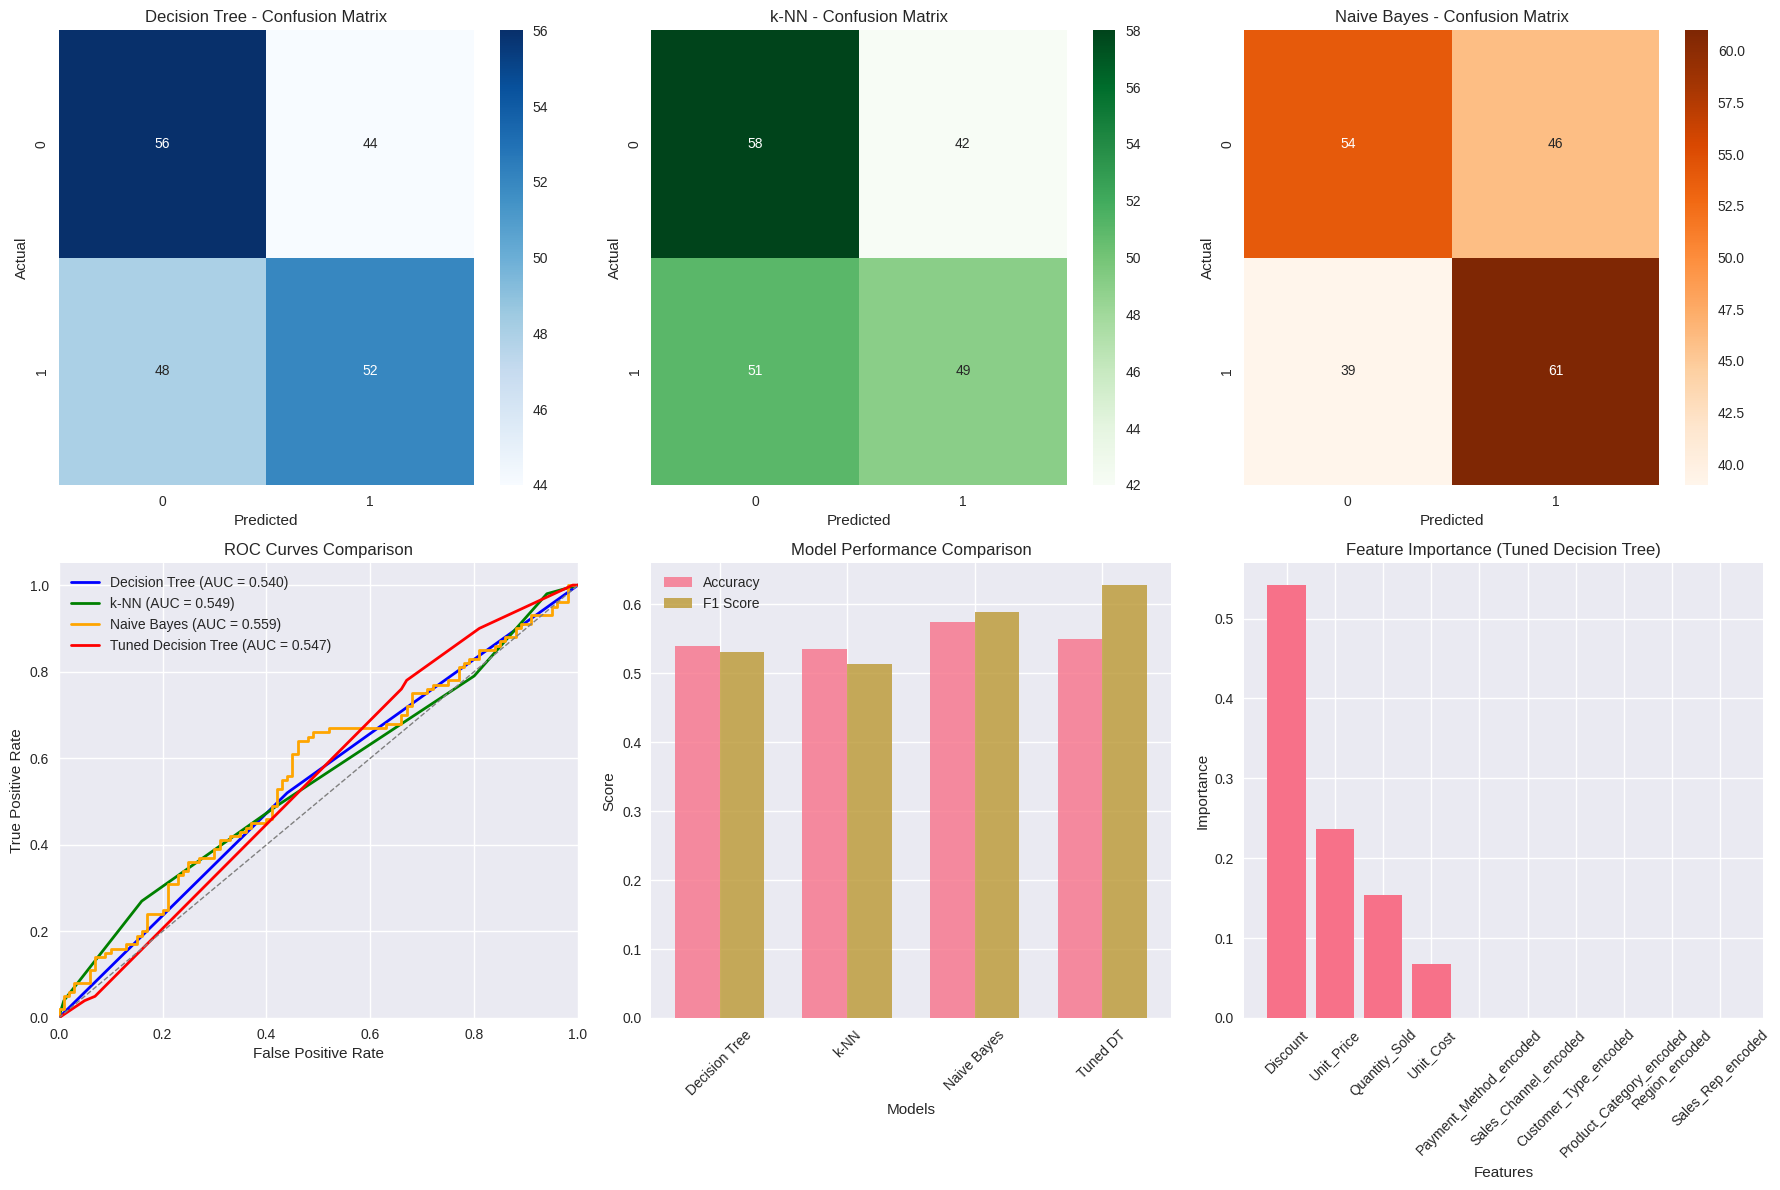

Classification model evaluation completed!


In [5]:
# ==========================================
# PART 4: MODEL EVALUATION VISUALIZATIONS
# ==========================================

print("\n" + "="*50)
print("PART 4: MODEL EVALUATION VISUALIZATIONS")
print("="*50)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrices
models_data = [
    ('Decision Tree', dt_pred, 'Blues'),
    ('k-NN', knn_pred, 'Greens'),
    ('Naive Bayes', nb_pred, 'Oranges')
]

for i, (name, pred, color) in enumerate(models_data):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=color, ax=axes[0, i])
    axes[0, i].set_title(f'{name} - Confusion Matrix')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')

# ROC Curves
models_prob_data = [
    ('Decision Tree', dt_prob, 'blue'),
    ('k-NN', knn_prob, 'green'),
    ('Naive Bayes', nb_prob, 'orange'),
    ('Tuned Decision Tree', best_dt_prob, 'red')
]

for name, prob, color in models_prob_data:
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    axes[1, 0].plot(fpr, tpr, color=color, lw=2,
                   label=f'{name} (AUC = {roc_auc:.3f})')

axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()

# Model Performance Comparison
model_names = ['Decision Tree', 'k-NN', 'Naive Bayes', 'Tuned DT']
accuracies = [dt_accuracy, knn_accuracy, nb_accuracy, best_dt_accuracy]
f1_scores = [dt_f1, knn_f1, nb_f1, best_dt_f1]

x_pos = np.arange(len(model_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, f1_scores, width, label='F1 Score', alpha=0.8)
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45)
axes[1, 1].legend()

# Feature Importance (for best Decision Tree)
feature_importance = best_dt.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

axes[1, 2].bar(range(len(feature_importance)), feature_importance[sorted_idx])
axes[1, 2].set_title('Feature Importance (Tuned Decision Tree)')
axes[1, 2].set_xlabel('Features')
axes[1, 2].set_ylabel('Importance')
axes[1, 2].set_xticks(range(len(feature_importance)))
axes[1, 2].set_xticklabels([feature_columns[i] for i in sorted_idx], rotation=45)

plt.tight_layout()
plt.show()

print("Classification model evaluation completed!")


PART 5: CLUSTERING ANALYSIS
Features used for clustering: ['Sales_Amount', 'Quantity_Sold', 'Unit_Cost', 'Unit_Price', 'Discount']

--- K-Means Clustering ---


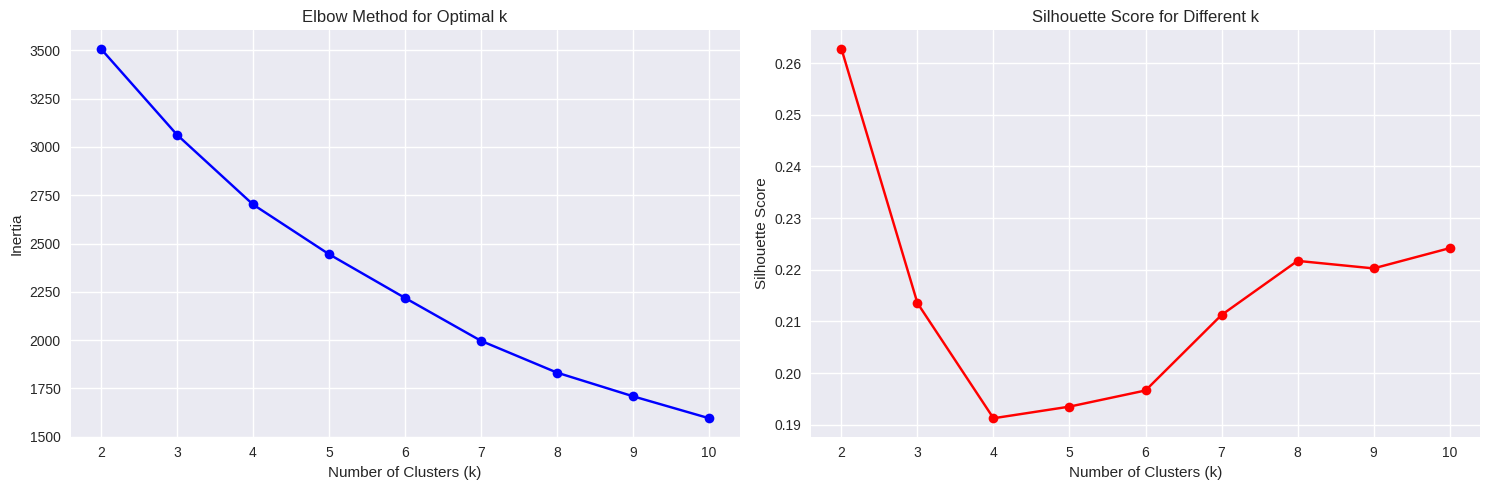

Optimal number of clusters: 4
Silhouette score for k=4: 0.1913

--- Hierarchical Clustering ---
Hierarchical clustering completed with 4 clusters
Silhouette score: 0.1405

--- DBSCAN Clustering ---
DBSCAN found 16 clusters and 896 noise points
Silhouette score: -0.4420


In [6]:
# ==========================================
# PART 5: CLUSTERING ANALYSIS
# ==========================================

print("\n" + "="*50)
print("PART 5: CLUSTERING ANALYSIS")
print("="*50)

# Prepare data for clustering (use numerical features)
clustering_features = ['Sales_Amount', 'Quantity_Sold', 'Unit_Cost',
                      'Unit_Price', 'Discount']
X_clustering = df[clustering_features]
X_clustering_scaled = StandardScaler().fit_transform(X_clustering)

print("Features used for clustering:", clustering_features)

# K-Means Clustering
print("\n--- K-Means Clustering ---")

# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal k (let's use k=4 based on elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_clustering_scaled)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette score for k={optimal_k}: {silhouette_score(X_clustering_scaled, kmeans_labels):.4f}")

# Add cluster labels to dataframe
df['KMeans_Cluster'] = kmeans_labels

# Hierarchical Clustering
print("\n--- Hierarchical Clustering ---")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_clustering_scaled)
df['Hierarchical_Cluster'] = hierarchical_labels

print(f"Hierarchical clustering completed with {optimal_k} clusters")
print(f"Silhouette score: {silhouette_score(X_clustering_scaled, hierarchical_labels):.4f}")

# DBSCAN Clustering
print("\n--- DBSCAN Clustering ---")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_clustering_scaled)
df['DBSCAN_Cluster'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points")
if n_clusters_dbscan > 1:
    print(f"Silhouette score: {silhouette_score(X_clustering_scaled, dbscan_labels):.4f}")


PART 6: CLUSTERING VISUALIZATION


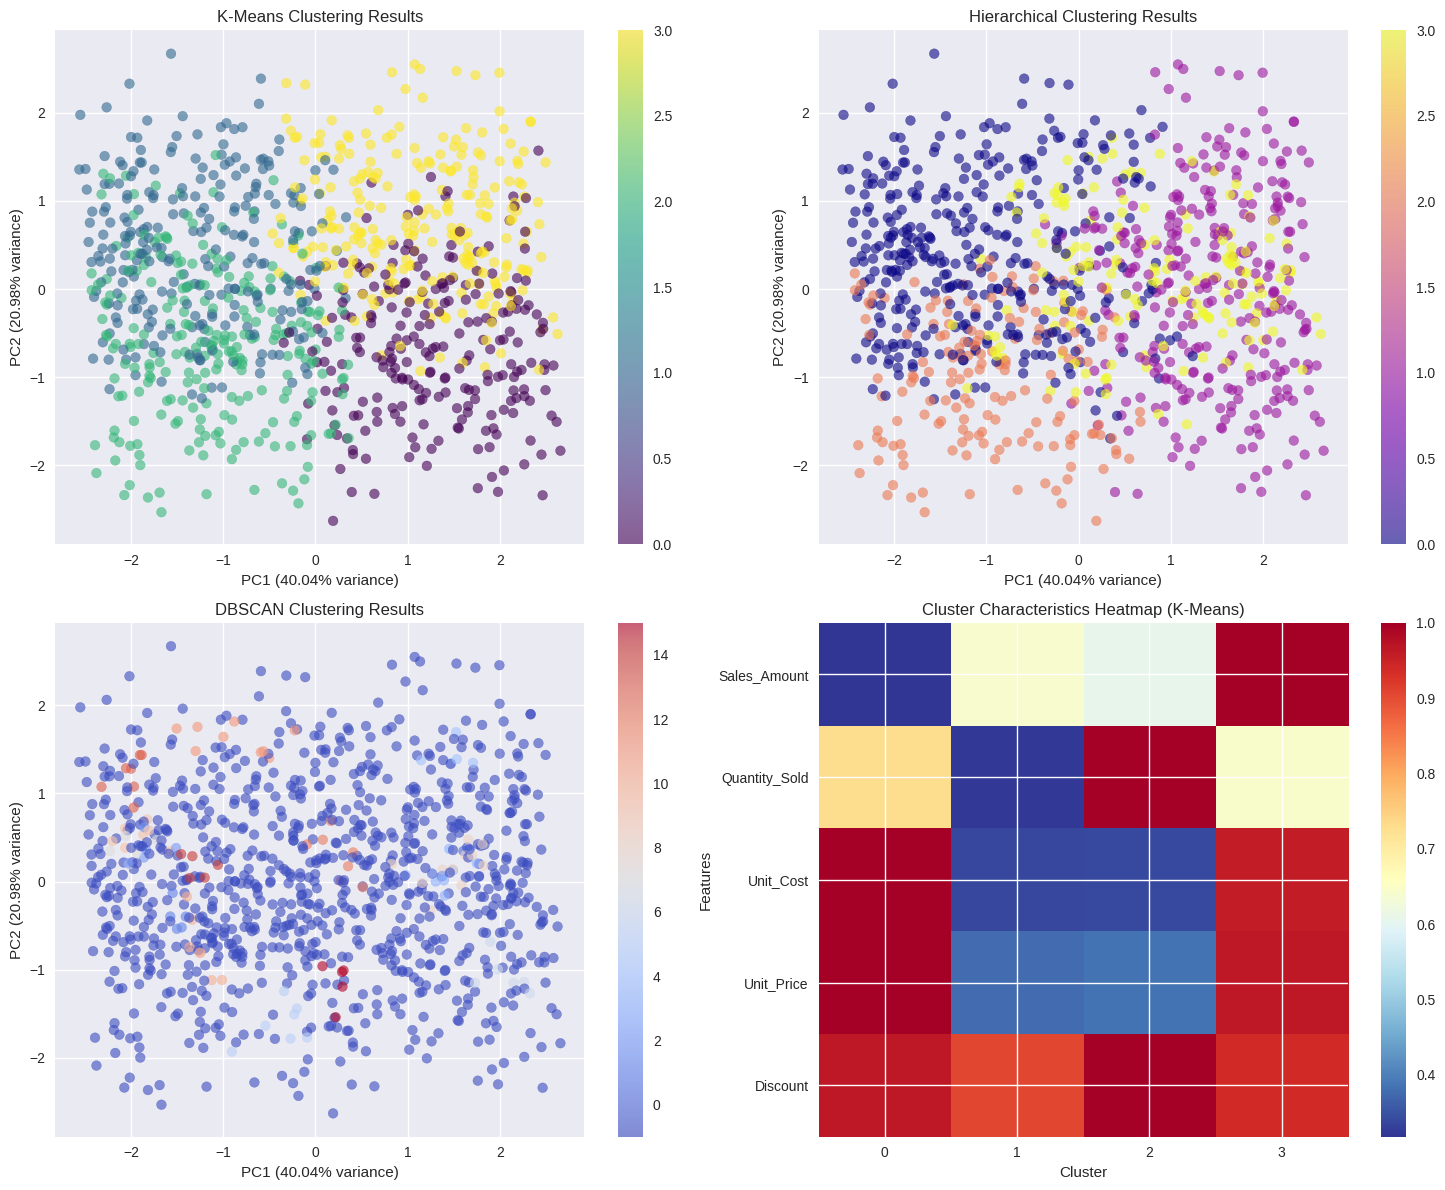


K-Means Cluster Summary:
                Sales_Amount  Quantity_Sold  Unit_Cost  Unit_Price  Discount
KMeans_Cluster                                                              
0                    2456.41          27.63    3764.15     4015.71      0.15
1                    4961.50          12.24    1274.06     1513.16      0.14
2                    4695.71          37.87    1283.95     1545.34      0.16
3                    7727.25          24.45    3605.51     3866.19      0.15

Cluster Sizes:
KMeans_Cluster
0    238
1    257
2    245
3    260
Name: count, dtype: int64


In [7]:
# ==========================================
# PART 6: CLUSTERING VISUALIZATION
# ==========================================

print("\n" + "="*50)
print("PART 6: CLUSTERING VISUALIZATION")
print("="*50)

# Use PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

# Create clustering visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Means visualization
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0, 0].set_title('K-Means Clustering Results')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter1, ax=axes[0, 0])

# Hierarchical visualization
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='plasma', alpha=0.6)
axes[0, 1].set_title('Hierarchical Clustering Results')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter2, ax=axes[0, 1])

# DBSCAN visualization
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='coolwarm', alpha=0.6)
axes[1, 0].set_title('DBSCAN Clustering Results')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter3, ax=axes[1, 0])

# Cluster characteristics (K-Means)
cluster_summary = df.groupby('KMeans_Cluster')[clustering_features].mean()
cluster_summary_normalized = cluster_summary.div(cluster_summary.max())

im = axes[1, 1].imshow(cluster_summary_normalized.T, cmap='RdYlBu_r', aspect='auto')
axes[1, 1].set_title('Cluster Characteristics Heatmap (K-Means)')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Features')
axes[1, 1].set_xticks(range(len(cluster_summary)))
axes[1, 1].set_yticks(range(len(clustering_features)))
axes[1, 1].set_yticklabels(clustering_features)
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Print cluster summaries
print("\nK-Means Cluster Summary:")
print(cluster_summary.round(2))

print("\nCluster Sizes:")
print(df['KMeans_Cluster'].value_counts().sort_index())


PART 7: ASSOCIATION RULE MINING
Transaction matrix shape: (1000, 24)
Sample of transaction data:
   Region_East  Region_North  Region_South  Region_West  \
0        False          True         False        False   
1        False         False         False         True   
2        False         False          True        False   
3        False         False          True        False   
4         True         False         False        False   

   Product_Category_Clothing  Product_Category_Electronics  \
0                      False                         False   
1                      False                         False   
2                      False                         False   
3                       True                         False   
4                      False                          True   

   Product_Category_Food  Product_Category_Furniture  Customer_Type_New  \
0                  False                        True              False   
1                  False

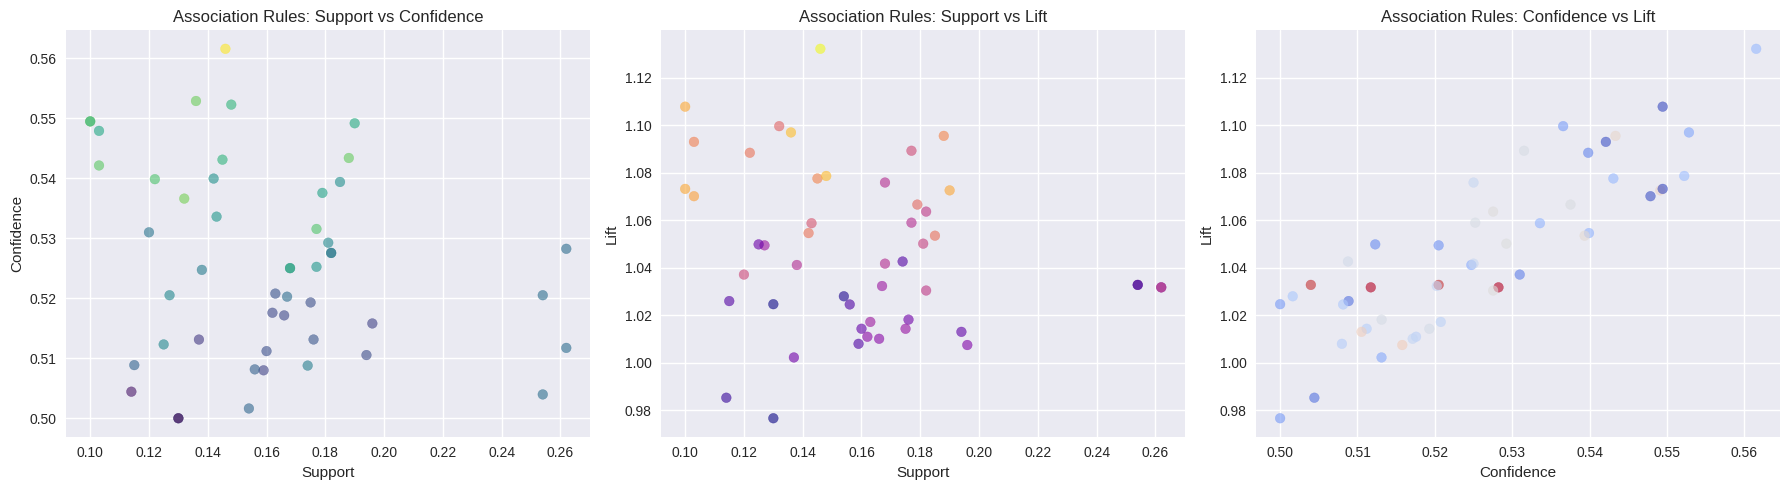

In [8]:
# ==========================================
# PART 7: ASSOCIATION RULE MINING
# ==========================================

print("\n" + "="*50)
print("PART 7: ASSOCIATION RULE MINING")
print("="*50)

# Prepare data for association rule mining
# Create transaction data using categorical variables and discretized numerical variables

# Discretize numerical variables
df['Sales_Amount_Category'] = pd.cut(df['Sales_Amount'], bins=3, labels=['Low_Sales', 'Medium_Sales', 'High_Sales'])
df['Quantity_Category'] = pd.cut(df['Quantity_Sold'], bins=3, labels=['Low_Qty', 'Medium_Qty', 'High_Qty'])
df['Discount_Category'] = pd.cut(df['Discount'], bins=3, labels=['Low_Discount', 'Medium_Discount', 'High_Discount'])

# Create transaction matrix
transaction_columns = ['Region', 'Product_Category', 'Customer_Type', 'Payment_Method',
                      'Sales_Channel', 'Sales_Amount_Category', 'Quantity_Category', 'Discount_Category']

# Create binary transaction matrix
transaction_data = pd.get_dummies(df[transaction_columns])
print("Transaction matrix shape:", transaction_data.shape)
print("Sample of transaction data:")
print(transaction_data.head())

# Apply Apriori algorithm
print("\nApplying Apriori algorithm...")
frequent_itemsets = apriori(transaction_data, min_support=0.1, use_colnames=True)
print(f"Found {len(frequent_itemsets)} frequent itemsets")

if len(frequent_itemsets) > 0:
    print("\nTop 10 frequent itemsets:")
    print(frequent_itemsets.nlargest(10, 'support'))

    # Generate association rules
    print("\nGenerating association rules...")
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

    if len(rules) > 0:
        print(f"Found {len(rules)} association rules")

        # Sort rules by lift
        rules_sorted = rules.sort_values('lift', ascending=False)

        print("\nTop 10 association rules (sorted by lift):")
        print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_string())

        # Visualize association rules
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Support vs Confidence
        axes[0].scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
        axes[0].set_xlabel('Support')
        axes[0].set_ylabel('Confidence')
        axes[0].set_title('Association Rules: Support vs Confidence')

        # Support vs Lift
        axes[1].scatter(rules['support'], rules['lift'], alpha=0.6, c=rules['confidence'], cmap='plasma')
        axes[1].set_xlabel('Support')
        axes[1].set_ylabel('Lift')
        axes[1].set_title('Association Rules: Support vs Lift')

        # Confidence vs Lift
        axes[2].scatter(rules['confidence'], rules['lift'], alpha=0.6, c=rules['support'], cmap='coolwarm')
        axes[2].set_xlabel('Confidence')
        axes[2].set_ylabel('Lift')
        axes[2].set_title('Association Rules: Confidence vs Lift')

        plt.tight_layout()
        plt.show()

    else:
        print("No association rules found with the given minimum confidence threshold.")
else:
    print("No frequent itemsets found with the given minimum support threshold.")

In [9]:
# ==========================================
# PART 8: INSIGHTS AND CONCLUSIONS
# ==========================================

print("\n" + "="*50)
print("PART 8: INSIGHTS AND CONCLUSIONS")
print("="*50)

print("KEY INSIGHTS FROM ANALYSIS:")
print("-" * 30)

print("\n1. CLASSIFICATION INSIGHTS:")
print(f"   • Best performing model: Tuned Decision Tree (Accuracy: {best_dt_accuracy:.4f}, F1: {best_dt_f1:.4f})")
print("   • Important features for predicting high sales:")
for i, importance in enumerate(best_dt.feature_importances_):
    if importance > 0.1:  # Show only important features
        print(f"     - {feature_columns[i]}: {importance:.3f}")

print("\n2. CLUSTERING INSIGHTS:")
print(f"   • Optimal number of clusters: {optimal_k}")
print("   • Customer segments identified:")
for cluster in range(optimal_k):
    cluster_data = df[df['KMeans_Cluster'] == cluster]
    avg_sales = cluster_data['Sales_Amount'].mean()
    avg_qty = cluster_data['Quantity_Sold'].mean()
    print(f"     - Cluster {cluster}: Avg Sales = ${avg_sales:.2f}, Avg Quantity = {avg_qty:.1f}")

print("\n3. ASSOCIATION RULE MINING INSIGHTS:")
if len(frequent_itemsets) > 0 and len(rules) > 0:
    print("   • Discovered meaningful patterns in customer behavior")
    print("   • Strong associations found between:")
    for _, rule in rules_sorted.head(3).iterrows():
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))
        print(f"     - {antecedent} → {consequent} (Lift: {rule['lift']:.2f})")
else:
    print("   • Limited patterns found - may need to adjust support/confidence thresholds")


PART 8: INSIGHTS AND CONCLUSIONS
KEY INSIGHTS FROM ANALYSIS:
------------------------------

1. CLASSIFICATION INSIGHTS:
   • Best performing model: Tuned Decision Tree (Accuracy: 0.5500, F1: 0.6281)
   • Important features for predicting high sales:
     - Quantity_Sold: 0.154
     - Unit_Price: 0.236
     - Discount: 0.542

2. CLUSTERING INSIGHTS:
   • Optimal number of clusters: 4
   • Customer segments identified:
     - Cluster 0: Avg Sales = $2456.41, Avg Quantity = 27.6
     - Cluster 1: Avg Sales = $4961.50, Avg Quantity = 12.2
     - Cluster 2: Avg Sales = $4695.71, Avg Quantity = 37.9
     - Cluster 3: Avg Sales = $7727.25, Avg Quantity = 24.4

3. ASSOCIATION RULE MINING INSIGHTS:
   • Discovered meaningful patterns in customer behavior
   • Strong associations found between:
     - Product_Category_Furniture → Customer_Type_Returning (Lift: 1.13)
     - Sales_Channel_Retail, Payment_Method_Credit Card → Customer_Type_Returning (Lift: 1.11)
     - Product_Category_Electronic